In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import sys  
!{sys.executable} -m pip install contractions

# Imports


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import numpy as np
from nltk import word_tokenize, pos_tag

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Cargar y preparar los datos


En primer lugar, cargamos los datos. Esta vez vamos a descargarlos de un usuario de github que ha compartido el típico dataset de "20newsGroups" en su cuenta

In [ ]:
dataset =pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [ ]:
# Mostrar el head del corpus


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


Se observa un  texto muy "sucio" que vamos a tener que "limpiar"

Vamos a comprobar el tamaño del dataset:

In [ ]:
print("Tenemos un conjunto de {} documentos".format())

Tenemos un conjunto de 11314 documentos


Despues, quitaremos las filsa con algún valor vacío (NA) y quitaremos los duplicados.

In [ ]:
print("Existen {} reviews duplicadas".format(np.sum(dataset.duplicated(subset=["content"]))))
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} noticias".format(dataset.shape[0]))

Existen 0 reviews duplicadas
Despues de quitar duplicados tenemos un conjunto de 11314 noticias


Observamos que el corpus está sin preprocesar. Hay correos electrónicos, símbolos de retorno de carro ("\n")... 

# Preprocesado

## Normalización

Vamos a transformar los datos. Comenzaremos trabajando con los componentes que "ensucian" el corpus: los correos electrónicos, presencia de "\n", comillas...

Lo vamos a hacer con regexp (visor online de regexp https://regex101.com/). Vamos a quitar los emails que se habían obserdao anteriormente y otros caracteres que "ensucian" el texto como retornos de carro, comillas.... Además eliminaremos la puntuación  y pasaremos a minúsclas el texto:


In [ ]:
# Cargar la librería de regular expressions
import re
import string
# Quita los emails presententes en un string (toma todos los string desde un espacio hasta la @ y todo lo que hay desde la @ hasta un espacio y lo sustituye por un "")
dataset['text_processed'] = dataset['content'].apply(lambda x: re.sub('\S*@\S*\s?', '', x))
# sustituir el \n
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: re.sub('\n', ' ', x))
# Quitar/eliminar las comillas
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: re.sub('\'', ' ', x))
# Convertir a lowercase
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: x.lower())
# Eliminar puntuación
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
dataset['text_processed']


El dataset es muy grande como para hacer las operaciones que queremos hacer durante la clase de forma rápida. Vamos a quedarnos con sólo una muestra.

In [ ]:
dataset2 = dataset.sample(500)

¿De qué ira el dataset? Una opción es hacer una wordcloud a partir de los datos anteriores. Esto se hace con la librería WordCloud.

Toma como entrada una frase que agrupa todos las frases del corpus, y genera el gráfico.

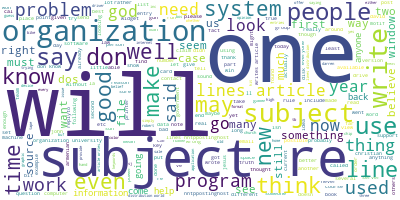

In [ ]:
from wordcloud import WordCloud
# Une las frases
long_string = ','.join(list(dataset2['text_processed'].values))
# Genera un objecto WordCloud 
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

Se observan muchas stopwords como "re" o el auxiliar "will". También las palabras well, even... Que no proporcionan información. Vemos muchas palabras a las que se les podría aplicar lematización... Es el momento de usar spacy!

In [ ]:
#!python -m spacy download en_core_web_sm
#!python -m spacy link en_core_web_sm en
#import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords
import string
import spacy
punctuations = string.punctuation
nlp = 
stop_words = 

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)

    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

Procesemos las frases con esa función:

In [ ]:
data_words = list()
for i in _____________________:
  _______________________

In [ ]:
data_words[0]

## Transformación

Para preprocesar datos de gensim utilizamos las funciones específicas con las que cuenta. 
Podemos utilizar el método `Phrases` 

In [ ]:
import gensim
# Construimos los modelos de bigramas y trigramas con gensim
# No devuelve trigramas o bigtamas en si mismos, si no que asocia palabras
# que aparecen juntas en mltitud de ocasiones
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Con esto todo va más rápido, pero ya no pueden modificarse lo anterior
# https://www.kite.com/python/docs/gensim.models.phrases.Phraser
# The goal of this class is to cut down memory consumption of `Phrases`, by discarding model state
# not strictly needed for the bigram detection task.
# Use this instead of `Phrases` if you do not need to update the bigram statistics with new documents any more.
bigram_mod = gensim.models.phrases.Phraser(bigram)

*Si* miramos los resultados de acontinuación, lo que hacen estas librerías es generar bigramas a partir de la similitud que tienen las palabras en un espacio vectorial (utiliza word2vec por detrás). 

Por ejemplo, los tokens "New" "York" son unidos en el proceso anterior a "New_York".  Algo similar ocurre con "computer_science". Basicamente la idea de los brigramas en gensim es la de agrupar palabras que generalmente se usen juntas, y no incorporar más variables al sistema.

In [ ]:
[bigram_mod[i] for i in data_words]

In [ ]:
bigram_mod[data_words[1]]

In [ ]:
type(bigram_mod)

gensim.models.phrases.Phraser

Ahora hay que aplicar los modelos a los datos. Para eso utilizamos las funciones que aparecen más abajo. 

ADemás, se ha incorporado la función filtra_tags, que permite coger tokens de una categoría específica. Muy util apra el topic_modeling

In [ ]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['day', 'hotel', 'room', 'great', 'night','staff','service'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Antes "entrenamos" el generador de bigrams, ahora se generan realmente en nuestros textos
def make_bigrams(textos):
    return [bigram_mod[doc] for doc in textos]

# Función para eliminar cierto tipo de tags
def filtra_tags(textos, tags_permitidas=['NOUN', 'ADJ', 'VERB', 'ADV']):
    textos_out = []
    for sent in textos:
        # Juntar los "bigrams"
        doc = nlp(_________________________) 
        # Filtra por etiqueta
        textos_out.append([token.text for token in doc if token.pos_ in tags_permitidas])
    return textos_out

Vamos a aplicar esas funciones:

In [ ]:
import spacy
# Remove Stop Words
#data_words_nostops = remove_stopwords(data_words)
# Crear Bigrams
data_words_bigrams = ______________________________

# Desabilitamos el "NER" y el "Parser" que no lo vamos a usar
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
#  Filtrar por categoría gramatical 
data_pos = ____________________________________

In [ ]:
print("Numero tokens antes de filtrar: {} tokens".format(len(data_words_bigrams[2])))
print("Numero tokens despues de filtrar: {} tokens".format(len(data_pos[2])))

In [ ]:
len(data_pos)

500

Despues de ese procesado tenemos un conjunto de 1000 documentos procesados y preparados para introudcir a un modelo de topic modeling

# Entramiento y validación

En primer lugar generamos un diccionario utilizando los objetos de Gensim. Ese diccionario contiene un método "doc2bow" que transforma el texto a vectores comprensibes por el modelo LDA.

In [ ]:
import gensim.corpora as corpora
# Creamos diccionario de términos 
id2word = ____________________
print(id2word)

Dictionary(7753 unique tokens: ['14k', 'bad', 'csutexasedu', 'drive', 'easily']...)


In [ ]:
# Asignamos a la variable texts nuestro corpus
texts = data_pos
# Transformamos nuestro corpus limpio a Bag of Words. 
corpus = [________________________________]
# View
print(corpus[2])

[(5, 1), (10, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 2), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]


Los modelos LDA necesitaban además de los vectores de entrada, un número de "topics" para ser entrenados. 
Como no sabemos a priori cuantos hay, creamos la función "calculo_valor_coherencia" que a partir dle corpus, el diccionario y otros valores calcula un modelo lda, calcula la coherencia entre sus topics y la devuelve

In [ ]:
# supporting function
def calculo_valor_coherencia(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_pos, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Vamos a calcular la coherencia suponiendo distintos números de topics. Por ejemplo de 1 a 22 en saltos de 2.

In [ ]:
import numpy as np
import tqdm
grid = {}
# Topics range
min_topics = 2
max_topics = 22
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha
alpha = 0.01
# Beta
beta = 0.9
# Validation sets
num_of_docs = len(corpus)
corpus_sets = corpus
corpus_title = '100% Corpus'
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

# Vamos a esperar mucho....
if 1 == 1:
    pbar = tqdm.tqdm()
    # Itera a lo largo del range de los topics
    for k in topics_range:
      # Calculamos coherencia para esos topics
      cv = calculo_valor_coherencia(corpus=corpus, dictionary=id2word,
                                    k=k, a=alpha, b=beta)
      # Guardamos los datos
      #model_results['Validation_Set'].append(corpus_title[i])
      model_results['Topics'].append(k)
      model_results['Alpha'].append(alpha)
      model_results['Beta'].append(beta)
      model_results['Coherence'].append(cv)

      pbar.update(1)
    pbar.close()

10it [01:15,  7.51s/it]


In [ ]:
model_results


{'Alpha': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 'Beta': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
 'Coherence': [0.2932354736271049,
  0.39351100143956175,
  0.3978277377704224,
  0.4802691135934921,
  0.457508355415965,
  0.5051650072848922,
  0.554601654884782,
  0.5459907984543403,
  0.665999751278972,
  0.5737894563705987],
 'Topics': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}

Ploteamos el resultado y observamos que el máximo de cogerencia está en torno a 13 topics.

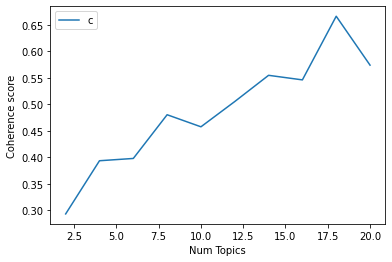

In [ ]:
# Show graph
import matplotlib.pyplot as plt
plt.plot(topics_range, model_results["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Entrenamos el modelo con el número de topics anteriormente calculado:

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=18, 
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      alpha=0.01,
                                      eta=0.9)

In [ ]:
model_topics = lda_model.show_topics(formatted=False)
print(lda_model.print_topics(num_words=3))

[(0, '0.005*"line" + 0.004*"article" + 0.004*"time"'), (1, '0.000*"ideological" + 0.000*"cultural" + 0.000*"praiseworthy"'), (2, '0.001*"gas" + 0.001*"biological" + 0.001*"patent"'), (3, '0.001*"b" + 0.000*"relegation" + 0.000*"final"'), (4, '0.001*"acceleration" + 0.000*"g" + 0.000*"longwinde"'), (5, '0.004*"tor" + 0.004*"pit" + 0.003*"period"'), (6, '0.000*"bedouin" + 0.000*"desertification" + 0.000*"fabrication"'), (7, '0.008*"people" + 0.005*"article" + 0.005*"line"'), (8, '0.000*"temporary" + 0.000*"vancouver" + 0.000*"tatoo"'), (9, '0.002*"disaster" + 0.001*"natural" + 0.001*"environmental"'), (10, '0.002*"save" + 0.001*"phl" + 0.001*"dineen"'), (11, '0.023*"entry" + 0.013*"file" + 0.009*"program"'), (12, '0.000*"guilty" + 0.000*"location" + 0.000*"amendment"'), (13, '0.001*"clementine" + 0.001*"darle" + 0.000*"acronym"'), (14, '0.001*"greek" + 0.000*"foreign" + 0.000*"negotiation"'), (15, '0.005*"line" + 0.004*"encryption" + 0.004*"government"'), (16, '0.010*"line" + 0.005*"use"

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim 
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

     |████████████████████████████████| 1.7MB 5.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=e4dc2ab9b785c88880be6e30e1c673f5e561d2d93b8765811bdc7d6dc178d004
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.091667  0.026727       1        1  29.046344
7      0.068098 -0.043555       2        1  26.112782
15     0.036599 -0.023764       3        1  12.086192
0      0.022898 -0.022276       4        1  11.884608
11     0.021766  0.077457       5        1  11.719246
17    -0.004994 -0.010380       6        1   5.470213
5     -0.040504 -0.003248       7        1   2.250520
10    -0.025073 -0.001125       8        1   0.617839
9     -0.017785 -0.000647       9        1   0.284881
2     -0.017584 -0.000596      10        1   0.157073
14    -0.017303  0.000077      11        1   0.102147
13    -0.017262  0.000144      12        1   0.084573
3     -0.016828  0.000267      13        1   0.069094
4     -0.016901  0.000111      14        1   0.061251
12    -0.016690  0.000213      15        1   0.013309
6     -0.016694  0.000215      16        1   0.013309
1     -0.016715  0.000167      17        1   0.013309
8     -0.016694  0.000214      18        1   0.013309, topic_info=            Term        Freq       Total Category  logprob  loglift
541        entry  105.000000  105.000000  Default  30.0000  30.0000
567         file   96.000000   96.000000  Default  29.0000  29.0000
766      program   71.000000   71.000000  Default  28.0000  28.0000
903            x   32.000000   32.000000  Default  27.0000  27.0000
86        window   49.000000   49.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1556       thick    0.000642    4.297348  Topic18  -8.9535   0.1159
1098        live    0.000642    8.505047  Topic18  -8.9537  -0.5669
2016  disclaimer    0.000642   10.575463  Topic18  -8.9537  -0.7848
4726   seriously    0.000642    7.349415  Topic18  -8.9539  -0.4211
990        light    0.000642   20.349375  Topic18  -8.9542  -1.4398

[946 rows x 6 columns], token_table=      Topic      Freq                                Term
term                                                     
6776      1  0.389077  15i6xdg50v9fd4q5zafnhhfse3jv43y2a1
6776      2  0.389077  15i6xdg50v9fd4q5zafnhhfse3jv43y2a1
6622      1  0.330102                                 21a
6622      2  0.330102                                 21a
6622      4  0.330102                                 21a
...     ...       ...                                 ...
239       4  0.177236                                year
239       5  0.245404                                year
239       6  0.040901                                year
7257      1  0.067304                               yeast
7257      2  0.874958                               yeast

[2119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 8, 16, 1, 12, 18, 6, 11, 10, 3, 15, 14, 4, 5, 13, 7, 2, 9])

Una vez lo hemos validado, podemos asociar topics a cada uno de los documentos.

Utilizando el método get_document_topics() sobre el texto del corpus que queramos podemos detectar la composición de temas que tiene cada documento:

In [ ]:
lda_model.get_document_topics(corpus[8])

[(0, 0.23348133), (7, 0.25442216), (17, 0.51082724)]

Podríamos ver la contribución de una palabra específica a cada uno de los topics con get_term_topics:

In [ ]:
lda_model.get_term_topics("people", minimum_probability=0.0001) #Get the most relevant topics to the given word.

